In [1]:
import os
import sys
sys.path.append('conditional-flow-matching')

In [2]:
# %load_ext autoreload
# %autoreload 2
# import os

import matplotlib.pyplot as plt
import torch
import torchdiffeq
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel, SuperResModel

In [3]:
import data

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [10]:
# data_dirs = ['/content/gdrive/MyDrive/Dataset/DIV2K_train_LR_wild',]
data_dirs = ['pixel_char/data/data/2',]
trainset = data.ImageDataset_8_16_32_64(data_dirs, store='ram', gray=False)
trainset.repeat = 1
trainset.set_scale(64)
print(len(trainset))

912                                                


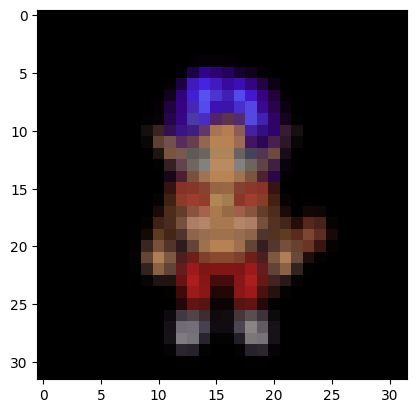

In [12]:
img = trainset[100][0]
img = img.permute(1,2,0).numpy()
plt.imshow(img)
plt.show()

In [13]:
batch_size = 64
n_epochs = 10

In [48]:
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [9]:
model = UNetModel(dim=(3, 32, 32), num_channels=128, num_res_blocks=1).to(device)

In [129]:
sigma = 0.01
FM = BronwnianBridgeFlowMatcher(sigma=sigma)

In [130]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [132]:
_ = model.train()
for epoch in range(20):
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x1 = data[1].to(device)
        x1 = x1 - 0.5
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        loss = torch.sum((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        print(f"epoch: {epoch}, steps: {i}, loss: {(loss.item() / vt.nelement())**(0.5):.4}")

epoch: 0, steps: 0, loss: 0.2878
epoch: 0, steps: 1, loss: 0.2826
epoch: 0, steps: 2, loss: 0.2454
epoch: 0, steps: 3, loss: 0.2449
epoch: 0, steps: 4, loss: 0.22
epoch: 0, steps: 5, loss: 0.1687
epoch: 0, steps: 6, loss: 0.1925
epoch: 0, steps: 7, loss: 0.2195
epoch: 0, steps: 8, loss: 0.1593
epoch: 0, steps: 9, loss: 0.219
epoch: 0, steps: 10, loss: 0.1562
epoch: 0, steps: 11, loss: 0.1653
epoch: 0, steps: 12, loss: 0.1527
epoch: 0, steps: 13, loss: 0.18
epoch: 1, steps: 0, loss: 0.1718
epoch: 1, steps: 1, loss: 0.1715
epoch: 1, steps: 2, loss: 0.1494
epoch: 1, steps: 3, loss: 0.1985
epoch: 1, steps: 4, loss: 0.1637
epoch: 1, steps: 5, loss: 0.1753
epoch: 1, steps: 6, loss: 0.2004
epoch: 1, steps: 7, loss: 0.1343
epoch: 1, steps: 8, loss: 0.1382
epoch: 1, steps: 9, loss: 0.1915
epoch: 1, steps: 10, loss: 0.1742
epoch: 1, steps: 11, loss: 0.1288
epoch: 1, steps: 12, loss: 0.1984
epoch: 1, steps: 13, loss: 0.1683
epoch: 2, steps: 0, loss: 0.1532
epoch: 2, steps: 1, loss: 0.1592
epoch: 

In [160]:
torch.save(model, "cfm_lowres.pt")

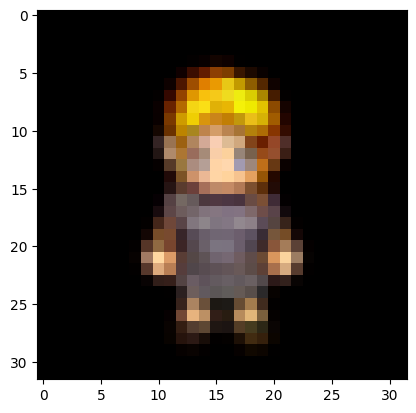

In [150]:
_ = model.eval()
with torch.no_grad():
    traj = torchdiffeq.odeint(
                lambda t, x: model.forward(t, x),
                torch.randn(1, 3, 32, 32, device=device),
                torch.linspace(0, 1.01, 2, device=device),
                atol=1e-4,
                rtol=1e-4,
                method="dopri5",
            )
img = traj[1,0].cpu().permute(1,2,0)
img = (img + 0.5).clip(0,1).numpy()
plt.imshow(img)
plt.show()

In [14]:
batch_size = 32
trainset.set_scale(64)
train_loader2 = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [15]:
model2 = SuperResModel(dim=(3, 64, 64), num_channels=256, num_res_blocks=1).to(device)

In [19]:
sigma = 0.01
FM = ConditionalFlowMatcher2(sigma=sigma)

In [36]:
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-5)

In [37]:
_ = model2.train()
for epoch in range(20):
    for i, data in enumerate(train_loader2):
        optimizer2.zero_grad()
        x1_low = data[0].to(device)
        x1 = data[1].to(device)
        x1_low = x1_low - 0.5
        x1 = x1 - 0.5
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model2(t, xt, low_res=x1_low)
        loss = torch.sum((vt - ut) ** 2)
        loss.backward()
        optimizer2.step()
        print(f"epoch: {epoch}, steps: {i}, loss: {(loss.item() / vt.nelement())**(0.5):.4}")

epoch: 0, steps: 0, loss: 0.1587
epoch: 0, steps: 1, loss: 0.159
epoch: 0, steps: 2, loss: 0.1897
epoch: 0, steps: 3, loss: 0.2184
epoch: 0, steps: 4, loss: 0.1738
epoch: 0, steps: 5, loss: 0.2289
epoch: 0, steps: 6, loss: 0.1589
epoch: 0, steps: 7, loss: 0.1861
epoch: 0, steps: 8, loss: 0.1476
epoch: 0, steps: 9, loss: 0.1593
epoch: 0, steps: 10, loss: 0.1905
epoch: 0, steps: 11, loss: 0.1468
epoch: 0, steps: 12, loss: 0.1714
epoch: 0, steps: 13, loss: 0.1683
epoch: 0, steps: 14, loss: 0.2554
epoch: 0, steps: 15, loss: 0.179
epoch: 0, steps: 16, loss: 0.2473
epoch: 0, steps: 17, loss: 0.1274
epoch: 0, steps: 18, loss: 0.1929
epoch: 0, steps: 19, loss: 0.1781
epoch: 0, steps: 20, loss: 0.1582
epoch: 0, steps: 21, loss: 0.1617
epoch: 0, steps: 22, loss: 0.183
epoch: 0, steps: 23, loss: 0.2275
epoch: 0, steps: 24, loss: 0.1834
epoch: 0, steps: 25, loss: 0.1905
epoch: 0, steps: 26, loss: 0.2069
epoch: 0, steps: 27, loss: 0.2005
epoch: 1, steps: 0, loss: 0.2035
epoch: 1, steps: 1, loss: 0.

In [50]:
torch.save(model2, "cfm_highres.pt")

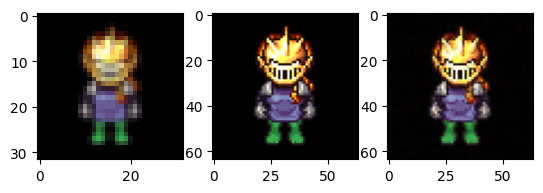

In [48]:
_ = model2.eval()

x1_low, x1_high = trainset[120]
x1_low_c = torch.clone(x1_low)
x1_low = x1_low - 0.5
x1_low = torch.unsqueeze(x1_low, dim=0).to(device)
with torch.no_grad():
    traj = torchdiffeq.odeint(
                lambda t, x: model2.forward(t, x, low_res=x1_low),
                torch.randn(1, 3, 64, 64, device=device),
                torch.linspace(0, 1.01, 2, device=device),
                atol=1e-4,
                rtol=1e-4,
                method="dopri5",
            )
img = traj[1,0].cpu().permute(1,2,0)
img = (img + 0.5).clip(0,1).numpy()
plt.subplot(1,3,3)
plt.imshow(img)
plt.subplot(1,3,2)
x1_high = x1_high.permute(1,2,0).numpy()
plt.imshow(x1_high)
plt.subplot(1,3,1)
x1_low_c = x1_low_c.permute(1,2,0).numpy()
plt.imshow(x1_low_c)
plt.show()

In [5]:
model = torch.load("cfm_lowres.pt", weights_only=False)

In [6]:
model2 = torch.load("cfm_highres.pt", weights_only=False)

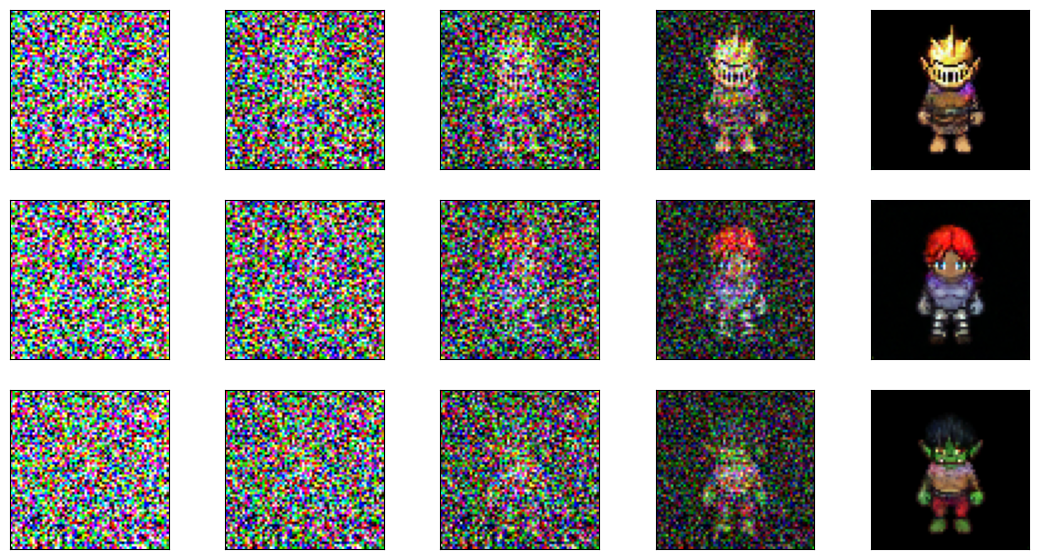

In [43]:
torch.manual_seed(8078365)
with torch.no_grad():
    traj1 = torchdiffeq.odeint(
                lambda t, x: model.forward(t, x),
                torch.randn(1, 3, 32, 32, device=device),
                torch.linspace(0, 1.01, 5, device=device),
                atol=1e-4,
                rtol=1e-4,
                method="dopri5",
            )
low_res = traj1[-1]

with torch.no_grad():
    traj1 = torchdiffeq.odeint(
                lambda t, x: model2.forward(t, x, low_res=low_res),
                torch.randn(1, 3, 64, 64, device=device),
                torch.linspace(0, 1.01, 5, device=device),
                atol=1e-4,
                rtol=1e-4,
                method="dopri5",
            )

torch.manual_seed(356)
with torch.no_grad():
    traj2 = torchdiffeq.odeint(
                lambda t, x: model.forward(t, x),
                torch.randn(1, 3, 32, 32, device=device),
                torch.linspace(0, 1.01, 5, device=device),
                atol=1e-4,
                rtol=1e-4,
                method="dopri5",
            )
low_res = traj2[-1]

with torch.no_grad():
    traj2 = torchdiffeq.odeint(
                lambda t, x: model2.forward(t, x, low_res=low_res),
                torch.randn(1, 3, 64, 64, device=device),
                torch.linspace(0, 1.01, 5, device=device),
                atol=1e-4,
                rtol=1e-4,
                method="dopri5",
            )

torch.manual_seed(811078365)
with torch.no_grad():
    traj3 = torchdiffeq.odeint(
                lambda t, x: model.forward(t, x),
                torch.randn(1, 3, 32, 32, device=device),
                torch.linspace(0, 1.01, 5, device=device),
                atol=1e-4,
                rtol=1e-4,
                method="dopri5",
            )
low_res = traj3[-1]

with torch.no_grad():
    traj3 = torchdiffeq.odeint(
                lambda t, x: model2.forward(t, x, low_res=low_res),
                torch.randn(1, 3, 64, 64, device=device),
                torch.linspace(0, 1.01, 5, device=device),
                atol=1e-4,
                rtol=1e-4,
                method="dopri5",
            )


fig, ax = plt.subplots(3,5, figsize=(13,7))
fig.subplots_adjust(left=0.1, right=0.9)
for i in range(5):
    x = traj1[i,0].cpu().permute(1,2,0)
    x = (x+0.5).clip(0,1).numpy()
    ax[0,i].imshow(x)
    ax[0,i].xaxis.set_ticks([])
    ax[0,i].yaxis.set_ticks([])
for i in range(5):
    x = traj2[i,0].cpu().permute(1,2,0)
    x = (x+0.5).clip(0,1).numpy()
    ax[1,i].imshow(x)
    ax[1,i].xaxis.set_ticks([])
    ax[1,i].yaxis.set_ticks([])
for i in range(5):
    x = traj3[i,0].cpu().permute(1,2,0)
    x = (x+0.5).clip(0,1).numpy()
    ax[2,i].imshow(x)
    ax[2,i].xaxis.set_ticks([])
    ax[2,i].yaxis.set_ticks([])
plt.savefig('example.png')
plt.show()
# plt.subplot(1,2,1)
# x1_low = low_res[0].cpu().permute(1,2,0)
# x1_low = (x1_low + 0.5).clip(0,1).numpy()
# plt.imshow(x1_low)
# plt.subplot(1,2,2)
# x1_high = high_res[0].cpu().permute(1,2,0)
# x1_high = (x1_high + 0.5).clip(0,1).numpy()
# plt.imshow(x1_high)